In [34]:
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt

In our exploration, we will delve into techniques aimed at reducing the variance in Monte Carlo simulations when valuing financial derivatives. The mathematical notations and practical examples we will use are drawn from Les Clewlow and Chris Strickland's book, "Implementing Derivatives Models."

While Monte Carlo simulation is an excellent method for approximating the values of options with complex payoffs or high dimensionality, obtaining a sufficiently accurate estimate often requires performing a large number of simulations, denoted as $M$ To address this computational demand and enhance efficiency, we can turn to Variance Reduction methods.

Variance Reduction methods operate on the same underlying principle as hedging an option position. In other words, they leverage strategies that reduce the variability of a hedged option portfolio. This reduction in variance results in more precise estimates and can significantly improve the efficiency of Monte Carlo simulations, making them a valuable tool for derivative valuation.

**Antithetic Variates**

Imagine you have two options, one on asset $S_1$ and another on asset $S_2$. These assets are in perfect negative correlation with each other and currently share the same price. The dynamics of $S_1$ and $S_2$ follow the Stochastic Differential Equations:

For $S_1$:
$$dS_{1,t} = rS_{1,t} dt + \sigma dS_{1,t} dz_t$$

For $S_2$:
$$dS_{2,t} = rS_{2,t} dt - \sigma dS_{2,t} dz_t$$

Because both assets have identical prices and volatility, the value of these two options is also the same. However, the real insight lies in the variance of a portfolio's payoff, containing both of these contracts, which is considerably lower than the variance of each individual contract. This approach effectively reduces the sharp spikes in the probability distribution of a single contract's payoff.

The core idea behind this technique is that when one option yields a positive payout, the other does not, and vice versa. This negative correlation between the two assets contributes to a smoother overall distribution of payoffs and risk reduction. As a result, it serves as a powerful method to enhance the efficiency of Monte Carlo simulations and derivative valuation.


**Implementation of Antithetic Variates**

In the context of valuing a European Call Option, one way to reduce variance is to create a hypothetical asset that is perfectly negatively correlated with the original asset. This approach is known as using antithetic variates. The implementation is straightforward, and it can significantly enhance the efficiency of Monte Carlo simulations. 

Consider the example of a European Call Option, where the simulated pay-offs follow the dynamics of asset St over time:

$$S_{t+\Delta t} = S_t \exp(\nu \Delta t + \sigma (\Delta Z))$$

Here, $(\Delta Z)$ represents a normally distributed random variable with mean 0 and variance $(\Delta t)$, equivalent to a standard normal distribution with mean 0 and standard deviation $(\sqrt{\Delta t})$, often denoted as $\epsilon_i$.

For contract simulation, you can define the following pay-off functions:

1. European Call Option Payoff for Simulation "i":
   $$C_{T,i} = \max(0, S \exp(\nu \Delta T + \sigma \sqrt{T} \epsilon_i) - K)$$

2. European Call Option Payoff for the Antithetic Variate of Simulation "i":
   $$\bar{C}_{T,i} = \max(0, S \exp(\nu \Delta T + \sigma \sqrt{T} (-\epsilon_i)) - K)$$

In these equations:
- $C_{T,i}$ represents the pay-off for the European Call Option in simulation "i."
- $\bar{C}_{T,i}$ represents the pay-off for the antithetic variate of the European Call Option in the same simulation.
- $S$ is the asset price.
- $\nu$ is a parameter defined as $\nu = r - \frac{1}{2}\sigma^2$.
- $\Delta T$ is the time increment.
- $\sigma$ is the volatility of the asset.
- $\epsilon_i$ and $-\epsilon_i$ are random variables following a standard normal distribution.

By considering both the original simulation and its antithetic variate, we effectively reduce the variance in our simulation results, making the estimation of option values more accurate and efficient.


In [35]:
# initial derivative parameters 
S = 101.15          #stock price
K = 98.01           #strike price
vol = 0.0991        #volatility (%)
r = 0.015            #risk-free rate (%)
N = 10              #number of time steps
M = 1000            #number of simulations
market_value = 3.86 #market price of option
T = ((datetime.date(2022,3,17)-datetime.date(2022,1,17)).days+1)/365    #time in years
print(T)

0.1643835616438356


**Slow Solution - Steps**

We typically decompose the process into gradual, discretized increments; however, in the case of a European Call Option, there's no need to take these steps as the discretization accurately mirrors the Stochastic Differential Equation (SDE).

In [36]:
# Precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)
# Standard Error Placeholders
sum_CT = 0
sum_CT2 = 0
# Monte Carlo Method
for i in range(M):
    lnSt1 = lnS
    lnSt2 = lnS
    for j in range(N):
        # Perfectly Negatively Correlated Assets
        epsilon = np.random.normal()
        lnSt1 = lnSt1 + nudt + volsdt*epsilon
        lnSt2 = lnSt2 + nudt - volsdt*epsilon
    
    ST1 = np.exp(lnSt1)
    ST2 = np.exp(lnSt2)
    CT = 0.5 * ( max(0, ST1 - K) + max(0, ST2 - K) )
    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT*CT
# Compute Expectation and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
SE = sigma/np.sqrt(M)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.84 with SE +/- 0.03


**Efficient Solution – Vectorized**

In this example, only a single step is required!

In straightforward processes where there is no need for SDE approximation, such as the case of Geometric Brownian Motion used in European Option Price calculations, we can efficiently simulate the variables at the final time step. This is because Brownian Motion scales with time and exhibits independent increments, simplifying the simulation process.

In [37]:
#precompute constants
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)
# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_lnSt1 = nudt + volsdt*Z 
delta_lnSt2 = nudt - volsdt*Z 
lnSt1 = lnS + np.cumsum(delta_lnSt1, axis=0)
lnSt2 = lnS + np.cumsum(delta_lnSt2, axis=0)
# Compute Expectation and SE
ST1 = np.exp(lnSt1)
ST2 = np.exp(lnSt2)
CT = 0.5 * ( np.maximum(0, ST1[-1] - K) + np.maximum(0, ST2[-1] - K) )
C0 = np.exp(-r*T)*np.sum(CT)/M
sigma = np.sqrt( np.sum( (CT - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.81 with SE +/- 0.03


**Comparing without Antithetic Variate**

In [38]:
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)
# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_lnSt = nudt + volsdt*Z 
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )
# Compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0w = np.exp(-r*T)*np.sum(CT[-1])/M
sigma = np.sqrt( np.sum( (CT[-1] - C0)**2) / (M-1) )
SEw = sigma/np.sqrt(M)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.81 with SE +/- 0.03


**Visualisation of Convergence**

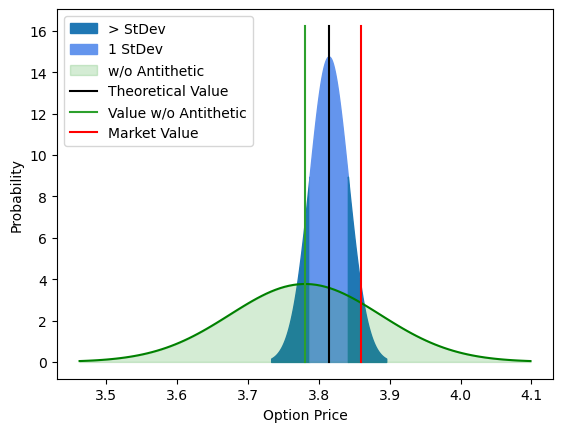

In [39]:

x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)
xw = np.linspace(C0w-3*SEw, C0w+3*SEw, 100)
s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)
sw = stats.norm.pdf(xw, C0w, SEw)
plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')
plt.plot(xw, sw, 'g-')
plt.fill_between(xw, sw, alpha=0.2, color='tab:green', label='w/o Antithetic')
plt.plot([C0,C0],[0, max(s2)*1.1], 'k',
        label='Theoretical Value')
plt.plot([C0w,C0w],[0, max(s2)*1.1], color='tab:green',
        label='Value w/o Antithetic')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r',
        label='Market Value')
plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()

**Advantages of Antithetic Variance Reduction**

- When utilizing pairs of $(ϵ_i, -ϵ_i)$ in the simulation, we can achieve a more accurate estimate using $M$ pairs of $(C_{T,i}, C¯_{T,i})$ compared to the use of $2M$ individual instances of $C_{T,i}$. This not only improves accuracy but also reduces computational costs, as generating the pair $(C_{T,i}, C¯_{T,i})$ is computationally more efficient than generating two separate instances of $C_{T,i}$.

- Additionally, this method guarantees that the mean of the normally distributed samples $\epsilon$ is precisely zero. This feature enhances the quality and reliability of the simulation results, making it a highly effective approach for variance reduction in Monte Carlo simulations.
